In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
def import_flowmeter(file_path, set_time_zero=True):
    # Load the data into a pandas dataframe
    flow_data = pd.read_csv(file_path, skiprows=1, names=['time', 'flow'])
    
    try:
        # Reverse the dataframe
        data_rev = flow_data.iloc[::-1]
        
        # Identify the final occurrence of a string containing letters in the 'time' column
        start_index = data_rev.loc[data_rev['time'].apply(
                lambda x: bool(re.search('[a-zA-Z]', x)))].first_valid_index()
        
        # Filter out any rows after this index
        flow_data = data_rev.loc[:(start_index + 1)].iloc[::-1]
    except: TypeError
    
    # Convert to floats
    flow_data = flow_data.astype(np.float64)
    
    # Get the nonzero flow values
    mask = flow_data['flow'] > 0
    
    # Make this mask slightly larger on each side
    mask = mask | mask.shift(1) | mask.shift(-1)
    
    # Set the time zero to the first time value
    if set_time_zero:
        flow_data['time'] = flow_data['time'] - flow_data['time'][mask].iloc[0]
    
    # Apply the mask
    return flow_data[mask]

In [4]:
def set_size(width, fraction=1, subplots=(1, 1), aspect=None):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    From https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    
    if aspect is None:
        aspect = golden_ratio

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [5]:
import matplotlib as mpl
print("Your style sheets are located at: {}".format(os.path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))

Your style sheets are located at: /Users/tommieverouden/miniconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib


In [6]:
plt.style.use('tex')

In [7]:
# Define the directory
directory = 'processed/'

# Get a list of all files in the directory
files = os.listdir(directory)

# Filter the list to include only files that end with displ_av.npy
files_displ_av = [file for file in files if file.endswith('displ_av.npy')]
files_profile = [file for file in files if file.endswith('displ.npy')]
files_pos = [file for file in files if file.endswith('window_pos.npy')]

# Sort the files in natural order
files_profile = natsorted(files_profile)
files_pos = natsorted(files_pos)
files_displ_av = natsorted(files_displ_av)

# Load all the files into a dictionary of numpy arrays
displ_av = {}
for file in files_displ_av:
    # Remove the extension and directory path from the filename
    key = os.path.splitext(os.path.basename(file))[0]
    key = key.replace('_displ_av', '')
    
    displ_av[key] = np.load(os.path.join(directory, file))

# Load all the files into a dictionary of numpy arrays
profile = {}
for file in files_profile:
    # Remove the extension and directory path from the filename
    key = os.path.splitext(os.path.basename(file))[0]
    key = key.replace('_displ', '')

    profile[key] = np.load(os.path.join(directory, file))
    
# Load all the files into a dictionary of numpy arrays
window_pos = {}
for file in files_pos:
    # Remove the extension and directory path from the filename
    key = os.path.splitext(os.path.basename(file))[0]
    key = key.replace('_window_pos', '')

    window_pos[key] = np.load(os.path.join(directory, file))
    
# Import calibration data
calibration = []

for i in range(1,5):
    calibration.append(np.load(os.path.join(f'data/calibration/pos{i}.npy')))

# AVERAGES

In [8]:
# fig, ax = plt.subplots(1, 1, figsize=set_size(246))
# fig, ax = plt.subplots(1, 1, figsize=set_size(500))

frame_rate = 40000 # fps
cross_section = 0.01 * 0.02 # m^2
start_threshold = 1 # px
positions = ['9.0 cm', '15.0 cm', '25.3 cm', '31.1 cm']

frames = {}
position = {}
start_frames = {}

# For each key in the dictionary, process
for key in displ_av.keys():
    
    # Get the position number
    position[key] = int(key[3])
    
    # Define a time array
    frames[key] = np.arange(0, displ_av[key].shape[0], 1)
    
    # Shift the time array such that t=0 is at the point where the displacement is above a certain threshold
    start_frames[key] = np.argmax(displ_av[key] > start_threshold) - 50
    frames[key] = frames[key] - start_frames[key]

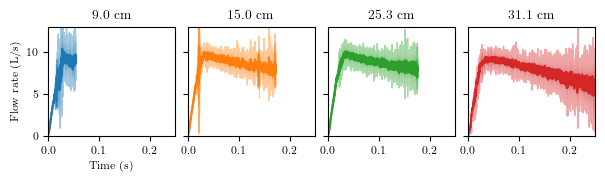

In [16]:
displ_av_avg = []
displ_av_std = []
frames_avg = []

# For each position
for i in range(1,5):

    # Get the keys that correspond to the position
    keys = [key for key in displ_av.keys() if position[key] == i]
    
    # Cut the data so it starts at the start frame
    displ_av_cut = {key: displ_av[key][start_frames[key]:] for key in keys}
    
    # Make sure all the data is the same length
    min_length = min([displ_av_cut[key].shape[0] for key in keys])
    displ_av_cut = {key: displ_av_cut[key][:min_length] for key in keys}
    
    # Average the cut data
    displ_av_avg.append(np.mean([displ_av_cut[key] for key in keys], axis=0).flatten())
    
    # Calculate the std
    displ_av_std.append(np.std([displ_av_cut[key] for key in keys], axis=0).flatten())
    
    # Use calibration to convert to L/s
    displ_av_avg[-1] = displ_av_avg[-1] / calibration[i-1][0] * cross_section * frame_rate
    
    # Define a time array in s
    frames_avg.append(np.arange(0, displ_av_avg[-1].shape[0], 1) / frame_rate)

# Plot the data
fig, axs = plt.subplots(1, 4, figsize=set_size(510, aspect=0.2),
                        sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

for i in range(4):
    # Plot the data
    axs[i].plot(frames_avg[i], displ_av_avg[i], c=f'C{i}')
    
    # Fill the area between the average and the standard deviation
    axs[i].fill_between(frames_avg[i], displ_av_avg[i] - displ_av_std[i], displ_av_avg[i] + displ_av_std[i], alpha=0.4, color=f'C{i}')
    
    # Set the title and labels
    axs[i].set_title(positions[i])
    axs[i].set_xlim(0, 0.25)
    axs[i].set_xticks([0, 0.1, 0.2])
    axs[i].set_ylim(0, 13)
    axs[0].set_ylabel('Flow rate (L/s)')
    axs[0].set_xlabel('Time (s)')
    
# fig.supxlabel('Time (s)')
# plt.

# axs[0].set_yticklabels([0, 0.5, 1, 1.5, 2])
# Add labels and a legend
# axs[i].set_xlabel('Time (s)')
# axs[i].set_ylabel('Volumetric flow rate (L/s)')
# axs[i].legend()
plt.show()

# Save and remove excess whitespace
fig.savefig('processed/flow_rate_av.pdf', format='pdf', bbox_inches='tight')

# FLOWMETER

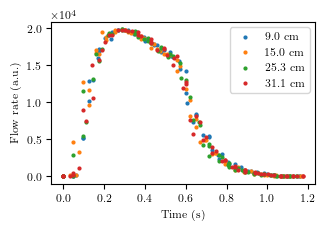

In [10]:
# Set the path to the flow meter data file
directory = 'data/flowmeter/'

# Get a list of all the files in the directory, filtering out hidden files
files = [file for file in os.listdir(directory) if file.endswith('.txt')]

# Import the data from all files in the directory
flowmeter = [import_flowmeter(directory + file) for file in files]

# Split the dataset according to the position number in the file name
flowmeter = [[flowmeter[j] for j in range(len(flowmeter)) if f'pos{i}' in files[j]]
             for i in range(1, 5)]

# Define a list of colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Define a list of marker styles
markers = ['o', 'v', '^', 's', '+', 'x', '*']

# Plot all data points, with separate colours for each position and symbols for each entry
fig, ax = plt.subplots(figsize=set_size(246))
for i in range(4):
    for j in range(len(flowmeter[i])):
        label = positions[i] if j == 1 else '_' 
        ax.scatter(flowmeter[i][j]['time'], flowmeter[i][j]['flow'],
                   color=f'C{i}', label=label, s=4)

# Use scientific notation on the y axis
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow rate (a.u.)')
ax.legend()
plt.show()
fig.savefig('processed/flow_meter.pdf', format='pdf', bbox_inches='tight')

# FLOW PROFILES

In [28]:
profile_avg = []
window_pos_avg = []
max_flow_index = []
# frames_avg = []

# For each position
for i in range(1,5):

    # Get the keys that correspond to the position
    keys = [key for key in displ_av.keys() if position[key] == i]
    
    # Cut the data so it starts at the start frame
    profile_cut = {key: profile[key][start_frames[key]:, :, :, 1] for key in keys}
    
    # Make sure all the data is the same length
    min_length = min([profile_cut[key].shape[0] for key in keys])
    profile_cut = {key: profile_cut[key][:min_length] for key in keys}
    
    # Average the cut data
    profile_avg.append(np.nanmean([profile_cut[key] for key in keys], axis=0)[:,:,0])
    
    # Use calibration to convert to m/s
    profile_avg[-1] = profile_avg[-1] / calibration[i-1][0] * frame_rate / 1000
    
    # Define position axis
    window_pos_avg.append(np.mean([window_pos[key][:, 0, 0] for key in keys], axis=0) / calibration[i-1][0])
    
    # Get the index of maximum displacement for each position
    max_flow_index.append(np.nanargmax(displ_av_avg[i-1]))
    
max_flow_index2 = [1114, 1238, 1335, 1363]

/var/folders/nt/rmh7rzx15n3_4wkj1k7rpbxw0000gn/T/ipykernel_49542/783776044.py:20: RuntimeWarning: Mean of empty slice
  profile_avg.append(np.nanmean([profile_cut[key] for key in keys], axis=0)[:,:,0])


In [27]:
test = displ_av_avg[2][:2000]

In [12]:
for i in range(4):
    print(max_flow_index[i], len(profile_avg[i]))

1114 2186
882 6904
1453 7048
2124 10537


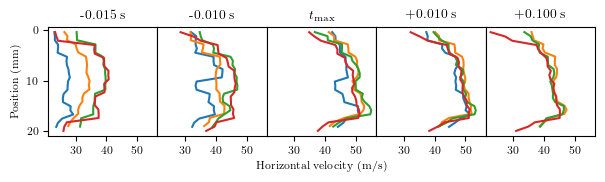

In [31]:
rel_indices = [-600, -400, 0, 400, 4000]
t_max_index = 2

# Plot the velocity profiles at different times
fig, ax = plt.subplots(1, 5, figsize=set_size(510, aspect=0.2), sharex=True)
plt.subplots_adjust(wspace=0)

mean_frames = 100

# For time
for i in range(len(rel_indices)):
    
    # For position
    for j in range(4):
        
        # If the data exists
        if max_flow_index2[j] + rel_indices[i] + mean_frames < len(profile_avg[j]):

            # Average the profile of the frames around the given time step
            mean_profile = np.nanmean([profile_avg[j][max_flow_index2[j] + rel_indices[i] + k, :] for k in range(mean_frames)], axis=0)

            # Plot the profile
            ax[i].plot(mean_profile, window_pos_avg[j], label=positions[j], c=f'C{j}')
    
    if i == t_max_index:
        ax[i].set_title(r'$t_{\rm{max}}$')
    elif i > t_max_index:
        ax[i].set_title(f'+{rel_indices[i] / frame_rate:.3f} s')
    elif i < t_max_index:
        ax[i].set_title(f'{rel_indices[i] / frame_rate:.3f} s')

    
    ax[i].invert_yaxis()
    if i > 0:
        ax[i].set_yticks([])

ax[0].set_ylabel('Position (mm)')
ax[2].set_xlabel('Horizontal velocity (m/s)')
plt.show()

fig.savefig('processed/flow_profiles.pdf', format='pdf', bbox_inches='tight')